# Import library`

In [9]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Untuk tampilan DataFrame yang lebih baik di notebook
from pathlib import Path
# --- Pengaturan Path untuk Impor Modul Internal ---
# Asumsi notebook ini ada di 'PROJECT_ROOT/src/models/'
# Kita perlu naik dua level untuk mencapai PROJECT_ROOT
project_root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

if project_root_path not in sys.path:
    sys.path.append(project_root_path)
    print(f"Path proyek ditambahkan: {project_root_path}")

# --- Impor Modul Internal Anda (Contoh) ---
# Sesuaikan dengan modul yang Anda miliki dan butuhkan
from src.utils.logger import setup_logging, get_logger # Jika Anda sudah memanggil setup_logging di main.py, cukup get_logger
# from src.etl import data_loader # Jika Anda punya fungsi load data di sana
# Asumsikan Anda sudah mengatur sys.path dengan benar di notebook Anda
from src.etl.data_validator import DataValidator, DataValidationError # Impor juga DataValidationError jika perlu menangkapnya
# from src.features import feature_extractor # Jika ada fitur yang perlu diekstrak secara dinamis
from src.visualization import plot_utils # Untuk plotting
from sklearn.model_selection import train_test_split
import logging

Path proyek ditambahkan: d:\Capstone\ML - Phishing Detection\Phishing-Detection


In [10]:
# --- 2. Impor dan Konfigurasi Logger ---
try:
    from src.utils.logger import setup_logging, get_logger

    # Panggil setup_logging SEKALI SAJA per sesi kernel notebook.
    # Atur log_level ke DEBUG untuk melihat semua pesan saat development.
    # Pastikan console_output=True.
    setup_logging(log_level=logging.DEBUG, console_output=True, file_output=True)

    # Dapatkan instance logger untuk notebook ini
    logger = get_logger(__name__) # atau logger = logging.getLogger(__name__)

    logger.info(">>>> Logger untuk notebook berhasil dikonfigurasi dan siap digunakan! <<<<")
except ImportError:
    print("GAGAL mengimpor modul logger. Pastikan sys.path sudah benar dan file logger.py ada di src/utils/")
    # Fallback ke basic config jika modul kustom tidak ditemukan, agar logger tetap bisa jalan
    logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)
    logger.warning("Menggunakan konfigurasi logging dasar karena modul kustom tidak ditemukan.")
except Exception as e:
    print(f"Error saat setup logger: {e}")
    logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)
    logger.error(f"Menggunakan konfigurasi logging dasar karena error: {e}")


# --- Sekarang logger sudah siap digunakan di sel-sel berikutnya ---

2025-06-07 14:17:05 - root - INFO - Konfigurasi logging selesai.
2025-06-07 14:17:05 - __main__ - INFO - >>>> Logger untuk notebook berhasil dikonfigurasi dan siap digunakan! <<<<


In [11]:
import logging
from tqdm import tqdm
from typing import Iterable, Optional, Any

# Impor logger dari modul logger.py Anda
# Menggunakan impor relatif karena diasumsikan progress_display.py dan logger.py
# berada dalam paket utils yang sama.
try:
    from .logger import get_logger
except ImportError:
    # Fallback jika dijalankan sebagai skrip atau struktur berbeda
    # Ini akan menggunakan basicConfig jika logger kustom tidak terjangkau
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger_fallback = logging.getLogger(__name__)
    logger_fallback.warning(
        "Tidak dapat mengimpor get_logger dari .logger. Menggunakan fallback logger dasar untuk progress_display."
    )
    # Definisikan fungsi get_logger dummy jika impor gagal agar kode di bawah tetap jalan
    def get_logger(name: str) -> logging.Logger:
        return logging.getLogger(name)

# Dapatkan logger untuk modul ini
logger = get_logger(__name__)

2025-06-07 14:17:09 - __main__ - WARNING - Tidak dapat mengimpor get_logger dari .logger. Menggunakan fallback logger dasar untuk progress_display.


In [12]:
# --- Pengaturan Path (jika belum ada) ---
# Asumsi notebook ini ada di 'PROJECT_ROOT/notebooks/' atau 'PROJECT_ROOT/src/models/'
# Sesuaikan path untuk mencapai PROJECT_ROOT
# Contoh jika di 'PROJECT_ROOT/notebooks/':
project_root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
logger.info(f"Path proyek ditambahkan: {project_root_path}")

2025-06-07 14:17:13 - __main__ - INFO - Path proyek ditambahkan: d:\Capstone\ML - Phishing Detection\Phishing-Detection


In [13]:
# Contoh di data_processor.py atau notebook
from src.utils.progress_display import track_progress
# ... dan Anda sudah memanggil setup_logging() dari src.utils.logger di entry point utama ...

In [14]:
# --- Memuat Data ---
# TODO: Sesuaikan path dan nama file
processed_data_path = os.path.join(project_root_path, "data", "interim", "dataset_clean.csv")
logger.info(f"Mencoba memuat data dari: {processed_data_path}")

try:
    df = pd.read_csv(processed_data_path)
    logger.info(f"Data berhasil dimuat. Shape: {df.shape}")

except FileNotFoundError:
    logger.error(f"File tidak ditemukan di: {processed_data_path}. Pastikan path dan nama file benar.")
    df = None # Atau tangani error sesuai kebutuhan
except Exception as e:
    logger.error(f"Error saat memuat data: {e}")
    df = None

2025-06-07 14:17:20 - __main__ - INFO - Mencoba memuat data dari: d:\Capstone\ML - Phishing Detection\Phishing-Detection\data\interim\dataset_clean.csv
2025-06-07 14:17:20 - __main__ - INFO - Data berhasil dimuat. Shape: (141214, 22)


In [15]:
df

,type,IP_Address,URL_Length,URL_Shortening,Double_Slash_Redirect_After_HTTPS,Hyphen_in_Domain_Name,Presence_of_Subdomain,Uses_HTTPS_Protocol,Favicon_Source_Consistency,Custom_Port_Usage,...,External_CSS_and_JS_Resources,External_Form_Submission,Form_Submits_to_Email_Address,HTTP_Response_Status_Content,Number_of_Redirects,Mouseover_Link_Manipulation,Right_Click_Disabled,Popup_Window_Usage,Iframe_Usage,URL_Blacklist_Status
0,0,1.0,59.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
1,1,1.0,77.0,1.0,1.0,1.0,6.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,1.0,51.0,-1.0,1.0,1.0,3.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,1.0,97.0,1.0,1.0,1.0,3.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,1.0,85.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141209,1,1.0,38.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
141210,0,1.0,49.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
141211,1,1.0,73.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
141212,0,1.0,38.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,1.0


In [15]:
# Ini hanya untuk demonstrasi atau debugging, bukan cara penggunaan utama
validator_instance = DataValidator(schema={}) # Skema kosong jika hanya tes duplikat
validator_instance._validate_duplicate_rows(df) # Panggil pada instance

# Lihat error yang terkumpul (jika ada)
collected_errors = validator_instance.validation_errors
if collected_errors:
    print("Error duplikasi yang terdeteksi (jika ada):")
    for err in collected_errors:
        if err['validation_type'] == "Baris Duplikat":
            print(f"- {err['message']}")
else:
    print("Tidak ada baris duplikat terdeteksi oleh _validate_duplicate_rows.")

# Reset error jika Anda mau pakai instance yang sama lagi untuk validasi penuh
validator_instance.validation_errors = []

2025-06-07 14:17:26 - src.etl.data_validator - DEBUG - DataValidator diinisialisasi dengan skema.
2025-06-07 14:17:26 - src.etl.data_validator - DEBUG - Memulai validasi baris duplikat.
2025-06-07 14:17:26 - src.etl.data_validator - ERROR - Validasi Gagal [DataFrame - Baris Duplikat]: Ditemukan 109508 baris duplikat dalam keseluruhan DataFrame.
2025-06-07 14:17:26 - src.etl.data_validator - DEBUG - Validasi baris duplikat selesai.
Error duplikasi yang terdeteksi (jika ada):
- Ditemukan 109508 baris duplikat dalam keseluruhan DataFrame.


In [16]:
# hapus data duplikat jika ada
if not df.empty:
    df = df.drop_duplicates()
    logger.info("Data duplikat telah dihapus.")
else:
    logger.warning("Data kosong, tidak ada yang dihapus.")
df

2025-06-07 14:17:37 - __main__ - INFO - Data duplikat telah dihapus.


,type,IP_Address,URL_Length,URL_Shortening,Double_Slash_Redirect_After_HTTPS,Hyphen_in_Domain_Name,Presence_of_Subdomain,Uses_HTTPS_Protocol,Favicon_Source_Consistency,Custom_Port_Usage,...,External_CSS_and_JS_Resources,External_Form_Submission,Form_Submits_to_Email_Address,HTTP_Response_Status_Content,Number_of_Redirects,Mouseover_Link_Manipulation,Right_Click_Disabled,Popup_Window_Usage,Iframe_Usage,URL_Blacklist_Status
0,0,1.0,59.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.00,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
1,1,1.0,77.0,1.0,1.0,1.0,6.0,-1.0,-1.0,1.0,...,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,1.0,51.0,-1.0,1.0,1.0,3.0,1.0,-1.0,1.0,...,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,1.0,97.0,1.0,1.0,1.0,3.0,-1.0,-1.0,1.0,...,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,1.0,85.0,1.0,1.0,1.0,2.0,1.0,-1.0,1.0,...,-1.00,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141172,0,1.0,26.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,38.46,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
141180,0,1.0,25.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,83.33,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
141188,0,1.0,28.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,92.31,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
141196,0,1.0,80.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,77.14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0


In [17]:
from sklearn.model_selection import train_test_split
from src.utils.logger import get_logger, setup_logging

# Inisialisasi logger
setup_logging()
logger = get_logger(__name__)

# Pisahkan fitur dan target
X = df.drop(columns='type')
y = df['type']
logger.info("Memisahkan fitur (X) dan target (y)...")

# Bagi menjadi 80% (train+val) dan 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
logger.info("Membagi data menjadi train+val (80%) dan test (20%).")

# Bagi lagi X_temp menjadi 75% train dan 25% val dari sisa 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
logger.info("Membagi data train+val menjadi train (60%) dan val (20%).")

# Log ukuran masing-masing dataset
logger.info(f"Train size: {len(X_train)}")
logger.info(f"Validation size: {len(X_val)}")
logger.info(f"Test size: {len(X_test)}")

# Log distribusi kelas
logger.info("Distribusi kelas pada dataset:")
logger.info(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
logger.info(f"Validation class distribution:\n{y_val.value_counts(normalize=True)}")
logger.info(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")



2025-06-07 14:17:41 - src.utils.logger - DEBUG - Konfigurasi logging sudah dilakukan sebelumnya.
2025-06-07 14:17:41 - __main__ - INFO - Memisahkan fitur (X) dan target (y)...
2025-06-07 14:17:41 - __main__ - INFO - Membagi data menjadi train+val (80%) dan test (20%).
2025-06-07 14:17:41 - __main__ - INFO - Membagi data train+val menjadi train (60%) dan val (20%).
2025-06-07 14:17:41 - __main__ - INFO - Train size: 19023
2025-06-07 14:17:41 - __main__ - INFO - Validation size: 6341
2025-06-07 14:17:41 - __main__ - INFO - Test size: 6342
2025-06-07 14:17:41 - __main__ - INFO - Distribusi kelas pada dataset:
2025-06-07 14:17:41 - __main__ - INFO - Train class distribution:
type
0    0.571782
1    0.428218
Name: proportion, dtype: float64
2025-06-07 14:17:41 - __main__ - INFO - Validation class distribution:
type
0    0.571834
1    0.428166
Name: proportion, dtype: float64
2025-06-07 14:17:41 - __main__ - INFO - Test class distribution:
type
0    0.571744
1    0.428256
Name: proportion, d

In [19]:
from lazypredict.Supervised import LazyClassifier
from src.utils.logger import get_logger
from sklearn.metrics import recall_score

# Ambil logger yang sudah di-setup sebelumnya
logger = get_logger(__name__)

# Inisialisasi LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=recall_score)
logger.info("LazyClassifier berhasil diinisialisasi.")

# Gunakan data train dan validasi untuk pelatihan dan evaluasi awal
logger.info("Memulai pelatihan dan evaluasi model menggunakan LazyClassifier (train vs validation)...")

models, predictions = clf.fit(X_train, X_val, y_train, y_val)

# Logging selesai dan tampilkan ringkasan
logger.info("Evaluasi LazyClassifier selesai. Berikut hasil performa model:")

# Tampilkan ke terminal (bisa diganti simpan ke CSV)
print(models)

# Jika ingin menyimpan hasil ke file
models.to_csv("hasil_lazyclassifier.csv", index=True)
logger.info("Hasil evaluasi disimpan ke hasil_lazyclassifier.csv")


2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2025-06-02 10:37:02 - graphviz._tools - DEBUG - deprecate positional ar

  0%|          | 0/29 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8146, number of negative: 10877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 19023, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,428218 -> initscore=-0,289123
[LightGBM] [Info] Start training from score -0,289123
2025-06-02 10:38:07 - __main__ - INFO - Evaluasi LazyClassifier selesai. Berikut hasil performa model:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.96               0.95     0.95      0.96   
XGBClassifier                      0.95               0.95     0.95      0.95   
LabelPropagation

In [20]:
models.sort_values(by='recall_score', ascending=False, inplace=True)
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
RandomForestClassifier,0.93,0.93,0.93,0.93,0.92,1.12
XGBClassifier,0.95,0.95,0.95,0.95,0.92,0.24
ExtraTreeClassifier,0.93,0.93,0.93,0.93,0.92,0.04
BaggingClassifier,0.94,0.94,0.94,0.94,0.92,0.37
DecisionTreeClassifier,0.93,0.93,0.93,0.93,0.91,0.07
ExtraTreesClassifier,0.93,0.93,0.93,0.93,0.91,0.80
LGBMClassifier,0.96,0.95,0.95,0.96,0.91,0.20
LabelPropagation,0.95,0.95,0.95,0.95,0.91,25.13
KNeighborsClassifier,0.94,0.94,0.94,0.94,0.90,0.49


In [21]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from src.utils.logger import get_logger

# Ambil logger
logger = get_logger(__name__)

# Inisialisasi model CatBoostClassifier (tidak verbose agar tidak banyak output)
model = CatBoostClassifier(random_seed=42, verbose=0)

logger.info("Memulai pelatihan model CatBoost...")

# Jika ada fitur kategori, kamu bisa definisikan kolom kategori, misal:
# cat_features = ['nama_kolom_kategori1', 'nama_kolom_kategori2']
# Pool data untuk CatBoost (jika ada kategori)
# train_pool = Pool(X_train, y_train, cat_features=cat_features)
# val_pool = Pool(X_val, y_val, cat_features=cat_features)

# Jika tidak ada fitur kategori, bisa langsung fit
model.fit(X_train, y_train, eval_set=(X_val, y_val))

logger.info("Pelatihan model selesai. Evaluasi di data validasi:")

# Prediksi di data validasi
y_val_pred = model.predict(X_val)

# Tampilkan classification report
report = classification_report(y_val, y_val_pred)
print(report)

logger.info(f"Classification report pada data validasi:\n{report}")

# Evaluasi di data test (opsional)
logger.info("Evaluasi model di data test:")
y_test_pred = model.predict(X_test)
test_report = classification_report(y_test, y_test_pred)
print(test_report)
logger.info(f"Classification report pada data test:\n{test_report}")


2025-06-02 10:38:12 - __main__ - INFO - Memulai pelatihan model CatBoost...
2025-06-02 10:38:21 - __main__ - INFO - Pelatihan model selesai. Evaluasi di data validasi:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3626
           1       0.99      0.91      0.95      2715

    accuracy                           0.96      6341
   macro avg       0.96      0.95      0.96      6341
weighted avg       0.96      0.96      0.96      6341

2025-06-02 10:38:21 - __main__ - INFO - Classification report pada data validasi:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3626
           1       0.99      0.91      0.95      2715

    accuracy                           0.96      6341
   macro avg       0.96      0.95      0.96      6341
weighted avg       0.96      0.96      0.96      6341

2025-06-02 10:38:21 - __main__ - INFO - Evaluasi model di data test:
              precision    

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight # Untuk menghitung class weights
import os
import datetime
# Assuming logger is defined and X_train, y_train, etc. are loaded

# --- 0. Hitung Class Weights ---
logger.info("Menghitung class weights...")
try:
    y_train_array = np.array(y_train)
    classes = np.unique(y_train_array)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train_array
    )
    class_weights_dict = dict(zip(classes, weights))
    logger.info(f"Class weights yang dihitung: {class_weights_dict}")
    if 0 not in class_weights_dict and (y_train_array == 0).any():
        logger.warning("Class 0 is present in y_train_array but missing from class_weights_dict keys. This might indicate an issue if not intended.")
    elif 0 not in class_weights_dict:
        logger.info("Class 0 is not a key in class_weights_dict (likely because it's not in y_train).")
except Exception as e:
    logger.warning(f"Gagal menghitung class weights: {e}. Melanjutkan tanpa class weights.")
    class_weights_dict = None

# --- PINDAHKAN BLOK INI KE ATAS ---
# Convert data to NumPy arrays before fitting and evaluation
logger.info(f"Type of X_train before conversion: {type(X_train)}")
logger.info(f"Type of y_train before conversion: {type(y_train)}")

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train).ravel() # .ravel() ensures it's 1D
X_val_np = np.asarray(X_val)
y_val_np = np.asarray(y_val).ravel()
X_test_np = np.asarray(X_test)
y_test_np = np.asarray(y_test).ravel()

# Log shapes to help debug
logger.info(f"Shape of X_train_np: {X_train_np.shape}")
logger.info(f"Shape of y_train_np: {y_train_np.shape}")
logger.info(f"Shape of X_val_np: {X_val_np.shape}")
logger.info(f"Shape of y_val_np: {y_val_np.shape}")
logger.info(f"Unique values in y_train_np for fitting: {np.unique(y_train_np)}")
# --- BATAS BLOK YANG DIPINDAHKAN ---

# --- 1. Definisi dan Kompilasi Model ---
logger.info("Mendefinisikan dan mengkompilasi model untuk klasifikasi biner dengan fokus recall...")
model = keras.Sequential([
    layers.Input(shape=(X_train_np.shape[1],)), # Sekarang X_train_np sudah terdefinisi
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Inisialisasi metrik Recall dan Precision
# For sigmoid output (1 neuron), do not set class_id.
# The metrics will default to calculating for the positive class (1).
# recall_metric = tf.keras.metrics.Recall(name='recall_class_1', class_id=1 if len(np.unique(y_train_np)) > 1 else None) # Previous
# precision_metric = tf.keras.metrics.Precision(name='precision_class_1', class_id=1 if len(np.unique(y_train_np)) > 1 else None) # Previous

recall_metric = tf.keras.metrics.Recall(name='recall_class_1')
precision_metric = tf.keras.metrics.Precision(name='precision_class_1')

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        recall_metric,
        precision_metric
    ]
)
logger.info("Model berhasil dibuat dan dikompilasi.")
model.summary()

# (The rest of your code for Callbacks, Data Conversion, model.fit, etc., would follow)
# Make sure you are using X_train_np, y_train_np, X_val_np, y_val_np in model.fit as per the previous suggestion.

# --- Persiapan Callbacks ---
# (Your callback preparation code remains the same)
logger.info("Mempersiapkan callbacks...")
MODEL_CHECKPOINT_DIR = "model_checkpoints_recall_focused"
TENSORBOARD_LOG_DIR = "tensorboard_logs_recall_focused"
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR, exist_ok=True)

# Pastikan 'val_recall_class_1' adalah nama metrik yang benar di history.history
checkpoint_filepath = os.path.join(MODEL_CHECKPOINT_DIR, "best_recall_model_untukplotfi.keras") # Nama file sederhana untuk yang terbaik
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_recall_class_1', # Ganti jika nama metrik di history berbeda
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_recall_class_1',
    patience=20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    min_lr=0.000001
)
log_dir_tensorboard = os.path.join(TENSORBOARD_LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir_tensorboard, histogram_freq=1)
callbacks_list = [
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    tensorboard_callback
]

# Convert data to NumPy arrays before fitting and evaluation
logger.info(f"Type of X_train before conversion: {type(X_train)}")
logger.info(f"Type of y_train before conversion: {type(y_train)}")
# If X_train might be a pandas DataFrame, its first dimension shape X_train.shape[0] must match y_train's.
# And X_train.shape[1] must match the Input layer's expectation.

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train).ravel() # .ravel() ensures it's 1D
X_val_np = np.asarray(X_val)
y_val_np = np.asarray(y_val).ravel()
X_test_np = np.asarray(X_test)
y_test_np = np.asarray(y_test).ravel()

# Log shapes to help debug
logger.info(f"Shape of X_train_np: {X_train_np.shape}")
logger.info(f"Shape of y_train_np: {y_train_np.shape}")
logger.info(f"Shape of X_val_np: {X_val_np.shape}")
logger.info(f"Shape of y_val_np: {y_val_np.shape}")
logger.info(f"Unique values in y_train_np for fitting: {np.unique(y_train_np)}")


# --- 2. Latih Model dengan Callbacks dan Class Weights ---
logger.info("Memulai pelatihan model dengan callbacks dan class weights...")
history = model.fit(
    X_train_np, y_train_np, # Use NumPy arrays
    validation_data=(X_val_np, y_val_np), # Use NumPy arrays
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)
logger.info("Pelatihan model selesai.")

# --- 3. Evaluasi Model Terbaik ---
logger.info("Mengevaluasi model...")
val_results = model.evaluate(X_val_np, y_val_np, verbose=0, return_dict=True) # Use NumPy arrays
logger.info(f"Hasil Evaluasi pada Data Validasi:")
for metric, value in val_results.items():
    logger.info(f"  - {metric}: {value:.4f}")

test_results = model.evaluate(X_test_np, y_test_np, verbose=0, return_dict=True) # Use NumPy arrays
logger.info(f"Hasil Evaluasi pada Data Tes:")
for metric, value in test_results.items():
    logger.info(f"  - {metric}: {value:.4f}")

# --- 4. Dapatkan Prediksi dan Sesuaikan Threshold ---
logger.info("Membuat prediksi probabilitas...")
y_pred_proba_val = model.predict(X_val_np) # Use NumPy arrays
y_pred_proba_test = model.predict(X_test_np) # Use NumPy arrays

default_threshold = 0.5
y_pred_val_default_thresh = (y_pred_proba_val > default_threshold).astype(int)
y_pred_test_default_thresh = (y_pred_proba_test > default_threshold).astype(int)

logger.info(f"\n--- Metrik dengan Threshold Default ({default_threshold}) ---")
logger.info("Data Validasi:")
# Ensure y_val_np is used for ground truth here
print(classification_report(y_val_np, y_pred_val_default_thresh, zero_division=0))
print("Confusion Matrix (Validasi):\n", confusion_matrix(y_val_np, y_pred_val_default_thresh))

logger.info("Data Tes:")
# Ensure y_test_np is used for ground truth here
print(classification_report(y_test_np, y_pred_test_default_thresh, zero_division=0))
print("Confusion Matrix (Tes):\n", confusion_matrix(y_test_np, y_pred_test_default_thresh))

custom_threshold = 0.4
y_pred_val_custom_thresh = (y_pred_proba_val > custom_threshold).astype(int)
y_pred_test_custom_thresh = (y_pred_proba_test > custom_threshold).astype(int)

logger.info(f"\n--- Metrik dengan Threshold Kustom ({custom_threshold}) untuk Recall Lebih Tinggi ---")
logger.info("Data Validasi:")
recall_val_custom = recall_score(y_val_np, y_pred_val_custom_thresh, pos_label=1, zero_division=0)
logger.info(f"Recall (Validasi, Custom Threshold) untuk kelas 1: {recall_val_custom:.4f}")
print(classification_report(y_val_np, y_pred_val_custom_thresh, zero_division=0))
print("Confusion Matrix (Validasi, Custom Threshold):\n", confusion_matrix(y_val_np, y_pred_val_custom_thresh))

logger.info("Data Tes:")
recall_test_custom = recall_score(y_test_np, y_pred_test_custom_thresh, pos_label=1, zero_division=0)
logger.info(f"Recall (Tes, Custom Threshold) untuk kelas 1: {recall_test_custom:.4f}")
print(classification_report(y_test_np, y_pred_test_custom_thresh, zero_division=0))
print("Confusion Matrix (Tes, Custom Threshold):\n", confusion_matrix(y_test_np, y_pred_test_custom_thresh))



2025-06-07 14:17:50 - __main__ - INFO - Menghitung class weights...
2025-06-07 14:17:50 - __main__ - INFO - Class weights yang dihitung: {0: 0.8744598694492967, 1: 1.1676282838202798}
2025-06-07 14:17:50 - __main__ - INFO - Type of X_train before conversion: <class 'pandas.core.frame.DataFrame'>
2025-06-07 14:17:50 - __main__ - INFO - Type of y_train before conversion: <class 'pandas.core.series.Series'>
2025-06-07 14:17:50 - __main__ - INFO - Shape of X_train_np: (19023, 21)
2025-06-07 14:17:50 - __main__ - INFO - Shape of y_train_np: (19023,)
2025-06-07 14:17:50 - __main__ - INFO - Shape of X_val_np: (6341, 21)
2025-06-07 14:17:50 - __main__ - INFO - Shape of y_val_np: (6341,)
2025-06-07 14:17:50 - __main__ - INFO - Unique values in y_train_np for fitting: [0 1]
2025-06-07 14:17:50 - __main__ - INFO - Mendefinisikan dan mengkompilasi model untuk klasifikasi biner dengan fokus recall...
2025-06-07 14:17:50 - __main__ - INFO - Model berhasil dibuat dan dikompilasi.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

2025-06-07 14:17:50 - __main__ - INFO - Mempersiapkan callbacks...
2025-06-07 14:17:50 - __main__ - INFO - Type of X_train before conversion: <class 'pandas.core.frame.DataFrame'>
2025-06-07 14:17:50 - __main__ - INFO - Type of y_train before conversion: <class 'pandas.core.series.Series'>
2025-06-07 14:17:50 - __main__ - INFO - Shape of X_train_np: (19023, 21)
2025-06-07 14:17:50 - __main__ - INFO - Shape of y_train_np: (19023,)
2025-06-07 14:17:50 - __main__ - INFO - Shape of X_val_np: (6341, 21)
2025-06-07 14:17:50 - __main__ - INFO - Shape of y_val_np: (6341,)
2025-06-07 14:17:50 - __main__ - INFO - Unique values in y_train_np for fitting: [0 1]
2025-06-07 14:17:50 - __main__ - INFO - Memulai pelatihan model dengan callbacks dan class weights...
Epoch 1/200
569/595 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6390 - loss: 1.4623 - precision_class_1: 0.5590 - recall_class_1: 0.6888
Epoch 1: val_recall_class_1 improved from -inf to 0.74401, saving model to model_checkpoints_recall_

2025-06-07 17:20:44 - __main__ - INFO - Menghitung feature importance menggunakan metode permutasi...
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/st

C:\Users\Dzulfahmi DA\AppData\Local\Temp\ipykernel_8472\2944616812.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


2025-06-07 17:21:58 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-06-07 17:21:58 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\Dzulfahmi DA\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-07 17:21:58 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\Dzulfahmi DA\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-07 17:21:58 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\Dzulfahmi DA\\AppData\\Local\\Programs

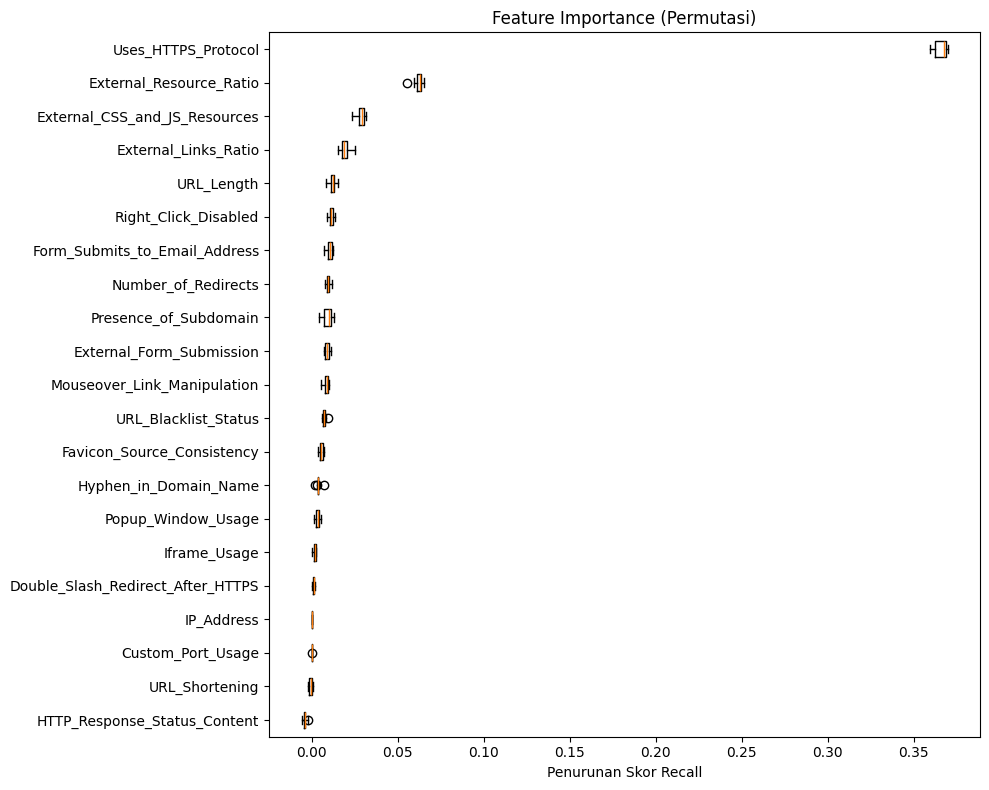

In [25]:
from sklearn.inspection import permutation_importance
# --- 6. Feature Importance dengan Permutasi ---
logger.info("Menghitung feature importance menggunakan metode permutasi...")

# Untuk menggunakan permutation_importance dari scikit-learn dengan model Keras,
# kita perlu membuat fungsi skoring kustom karena metrik recall tidak langsung tersedia.
def recall_scorer(model, X, y):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > 0.5).astype(int)
    return recall_score(y, y_pred)

# Lakukan kalkulasi permutasi
# n_repeats menentukan berapa kali permutasi dilakukan untuk setiap fitur untuk hasil yang lebih stabil.
result = permutation_importance(
    model, X_test_np, y_test_np,
    scoring=recall_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

# Ambil nama fitur
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_train_np.shape[1])]

# Urutkan fitur berdasarkan tingkat kepentingannya
sorted_idx = result.importances_mean.argsort()

# --- Visualisasi Hasil ---
logger.info("Membuat plot feature importance...")
print("\nMenampilkan Plot Feature Importance (Permutasi)...")

fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(feature_names)[sorted_idx])
ax.set_title("Feature Importance (Permutasi)")
ax.set_xlabel("Penurunan Skor Recall")
fig.tight_layout()
plt.show()

In [24]:
# plot_recall_comparison
import matplotlib.pyplot as plt

def plot_recall_comparison(history, test_recall, recall_metric_name='recall_class_1', val_recall_metric_name=None):
    """
    Membuat plot perbandingan metrik recall dari training, validasi, dan tes.

    Args:
        history (keras.callbacks.History): Objek history dari model.fit().
        test_recall (float): Nilai recall dari data tes.
        recall_metric_name (str): Nama metrik recall di history.history (untuk training).
                                   Defaultnya 'recall_class_1'.
        val_recall_metric_name (str, optional): Nama metrik recall validasi di history.history.
                                                Jika None, akan di-generate dari recall_metric_name.
    """
    if val_recall_metric_name is None:
        val_recall_metric_name = f'val_{recall_metric_name}'

    if recall_metric_name not in history.history:
        print(f"Error: Metrik training '{recall_metric_name}' tidak ditemukan dalam history.")
        return
    if val_recall_metric_name not in history.history:
        print(f"Error: Metrik validasi '{val_recall_metric_name}' tidak ditemukan dalam history.")
        return

    train_recall = history.history[recall_metric_name]
    val_recall = history.history[val_recall_metric_name]
    epochs = range(1, len(train_recall) + 1)

    plt.figure(figsize=(12, 7)) # Sedikit diperbesar untuk kenyamanan

    plt.plot(epochs, train_recall, 'b-o', label=f'Training Recall ({train_recall[-1]:.4f})', markersize=5)
    plt.plot(epochs, val_recall, 'g-s', label=f'Validation Recall ({val_recall[-1]:.4f})', markersize=5)
    plt.axhline(y=test_recall, color='r', linestyle='--', linewidth=2, label=f'Test Recall ({test_recall:.4f})')

    best_val_recall_epoch = val_recall.index(max(val_recall)) + 1
    best_val_recall = max(val_recall)
    plt.scatter(best_val_recall_epoch, best_val_recall, marker='*', color='purple', s=200, zorder=5,
                label=f'Best Validation Recall ({best_val_recall:.4f}) at Epoch {best_val_recall_epoch}')

    plt.title('Perbandingan Recall: Training, Validasi, dan Tes', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Menyesuaikan batas y agar plot lebih informatif
    min_recall_overall = min(min(train_recall), min(val_recall), test_recall)
    max_recall_overall = max(max(train_recall), max(val_recall), test_recall)
    padding = (max_recall_overall - min_recall_overall) * 0.05 # 5% padding
    plt.ylim([max(0, min_recall_overall - padding), min(1.0, max_recall_overall + padding)])


    if len(epochs) <= 20 : # Jika epoch sedikit, tampilkan semua
        plt.xticks(epochs)
    else: # Jika epoch banyak, atur agar tidak tumpang tindih
        tick_interval = max(1, len(epochs) // 10) # Sekitar 10 ticks
        plt.xticks(range(1, len(epochs) + 1, tick_interval))

    plt.tight_layout() # Agar tidak ada label yang terpotong
    plt.show()

2025-06-02 10:42:16 - __main__ - INFO - Recall validasi terbaik (0.9116) tercapai pada epoch: 8.
2025-06-02 10:42:16 - __main__ - INFO - Menggunakan model saat ini (diasumsikan bobot terbaik dari EarlyStopping atau akhir training).
2025-06-02 10:42:16 - __main__ - INFO - Menghitung recall pada data tes menggunakan model dari epoch dengan val_recall terbaik...
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
2025-06-02 10:42:17 - __main__ - INFO - Recall (Tes) dari model dengan val_recall terbaik: 0.9087

Laporan Klasifikasi (Tes) untuk Model dengan Val Recall Terbaik:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3626
           1       0.95      0.91      0.93      2716

    accuracy                           0.94      6342
   macro avg       0.94      0.94      0.94      6342
weighted avg       0.94      0.94      0.94      6342


Confusion Matrix (Tes) untuk Model dengan Val Recall Terbaik:
[[3503  123]
 [ 248 2468]]
2025-06-02 10:

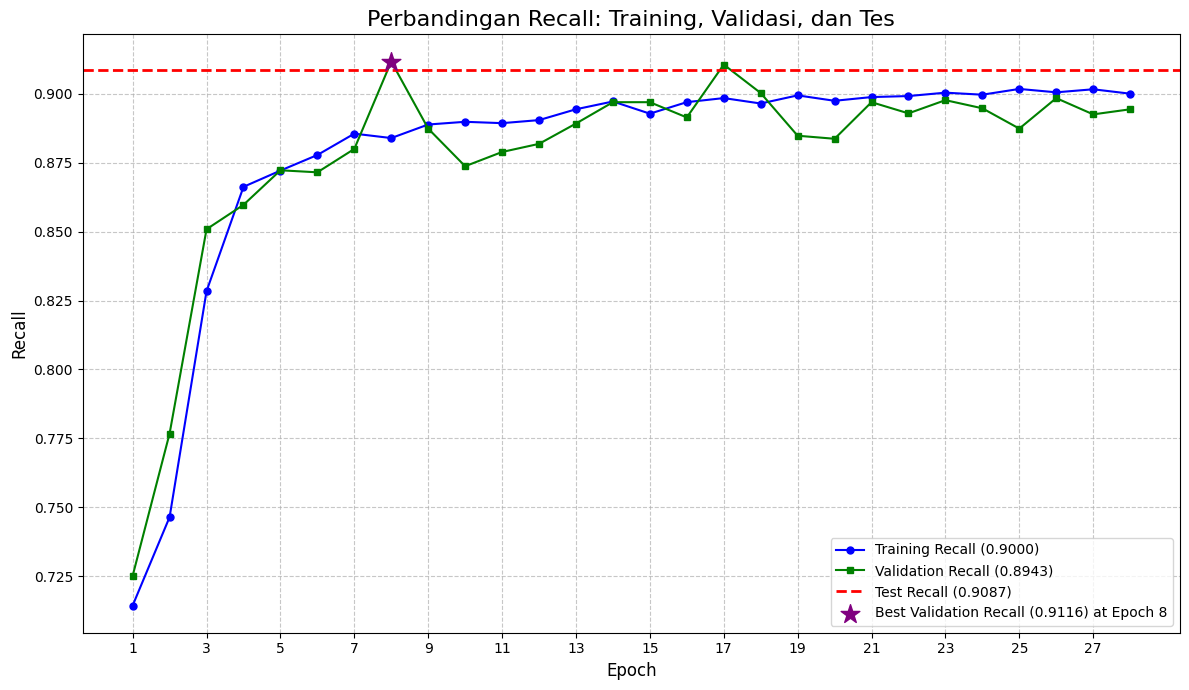

In [25]:
# ... (setelah model.fit() selesai) ...

history_dict = history.history

# Pastikan nama metrik recall validasi benar (sesuai yang ada di history.history)
# Biasanya Keras menambahkan 'val_' prefix. Jika metrik Anda 'recall_class_1', maka di history menjadi 'val_recall_class_1'
NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY = 'val_recall_class_1' # SESUAIKAN JIKA PERLU

if NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY not in history_dict:
    logger.error(f"Metrik '{NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY}' tidak ditemukan dalam history. Periksa nama metrik di model.compile() dan callbacks.")
    # Set test_recall_value ke nilai placeholder atau tangani error
    test_recall_value_untuk_plot = 0.0 
else:
    val_recall_values = history_dict[NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY]
    best_val_recall_epoch_idx = np.argmax(val_recall_values)
    best_val_recall = val_recall_values[best_val_recall_epoch_idx]
    best_epoch_number = best_val_recall_epoch_idx + 1
    
    logger.info(f"Recall validasi terbaik ({best_val_recall:.4f}) tercapai pada epoch: {best_epoch_number}.")

    # Pilih model yang akan digunakan untuk evaluasi tes:
    # Opsi 1: Jika EarlyStopping(restore_best_weights=True, monitor='val_recall_class_1', mode='max') digunakan,
    #         maka 'model' saat ini sudah memiliki bobot terbaik.
    model_untuk_evaluasi_tes = model
    logger.info("Menggunakan model saat ini (diasumsikan bobot terbaik dari EarlyStopping atau akhir training).")

    # Opsi 2: Jika Anda mengandalkan ModelCheckpoint untuk menyimpan file model terbaik secara terpisah
    #         dan EarlyStopping mungkin memantau metrik lain atau tidak restore_best_weights.
    # best_model_path = os.path.join(MODEL_CHECKPOINT_DIR, "best_recall_model.keras") # Sesuaikan dengan nama file Anda
    # if os.path.exists(best_model_path):
    #     logger.info(f"Memuat model terbaik dari checkpoint: {best_model_path}")
    #     model_untuk_evaluasi_tes = keras.models.load_model(best_model_path)
    # else:
    #     logger.warning(f"File model checkpoint terbaik tidak ditemukan di {best_model_path}. Menggunakan model akhir dari training.")
    #     model_untuk_evaluasi_tes = model


    # Hitung recall pada data tes menggunakan model_untuk_evaluasi_tes
    logger.info(f"Menghitung recall pada data tes menggunakan model dari epoch dengan val_recall terbaik...")
    y_pred_proba_test = model_untuk_evaluasi_tes.predict(X_test)
    
    # Sesuaikan cara mendapatkan label prediksi berdasarkan output layer Anda
    if model_untuk_evaluasi_tes.layers[-1].units == 1 and model_untuk_evaluasi_tes.layers[-1].activation == keras.activations.sigmoid:
        # Output sigmoid (1 neuron)
        y_pred_test_labels = (y_pred_proba_test > 0.5).astype(int) # Gunakan threshold 0.5 atau threshold kustom Anda
    else:
        # Output softmax (misalnya 2 neuron)
        y_pred_test_labels = np.argmax(y_pred_proba_test, axis=1)

    test_recall_value_untuk_plot = recall_score(y_test, y_pred_test_labels, pos_label=1, zero_division=0)
    logger.info(f"Recall (Tes) dari model dengan val_recall terbaik: {test_recall_value_untuk_plot:.4f}")

    # Juga tampilkan classification report lengkap untuk model terbaik ini pada data tes
    print("\nLaporan Klasifikasi (Tes) untuk Model dengan Val Recall Terbaik:")
    print(classification_report(y_test, y_pred_test_labels, zero_division=0))
    print("\nConfusion Matrix (Tes) untuk Model dengan Val Recall Terbaik:")
    print(confusion_matrix(y_test, y_pred_test_labels))


# Panggil fungsi plot Anda dengan nilai test_recall yang sudah disesuaikan
# Pastikan NAMA_METRIK_RECALL_TRAINING_DI_HISTORY juga benar
NAMA_METRIK_RECALL_TRAINING_DI_HISTORY = 'recall_class_1' # SESUAIKAN JIKA PERLU

if NAMA_METRIK_RECALL_TRAINING_DI_HISTORY in history_dict and NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY in history_dict:
    plot_recall_comparison(
        history,
        test_recall_value_untuk_plot,
        recall_metric_name=NAMA_METRIK_RECALL_TRAINING_DI_HISTORY,
        val_recall_metric_name=NAMA_METRIK_RECALL_VALIDASI_DI_HISTORY
    )
else:
    logger.error("Satu atau lebih nama metrik recall tidak ditemukan di history. Plot tidak bisa dibuat.")

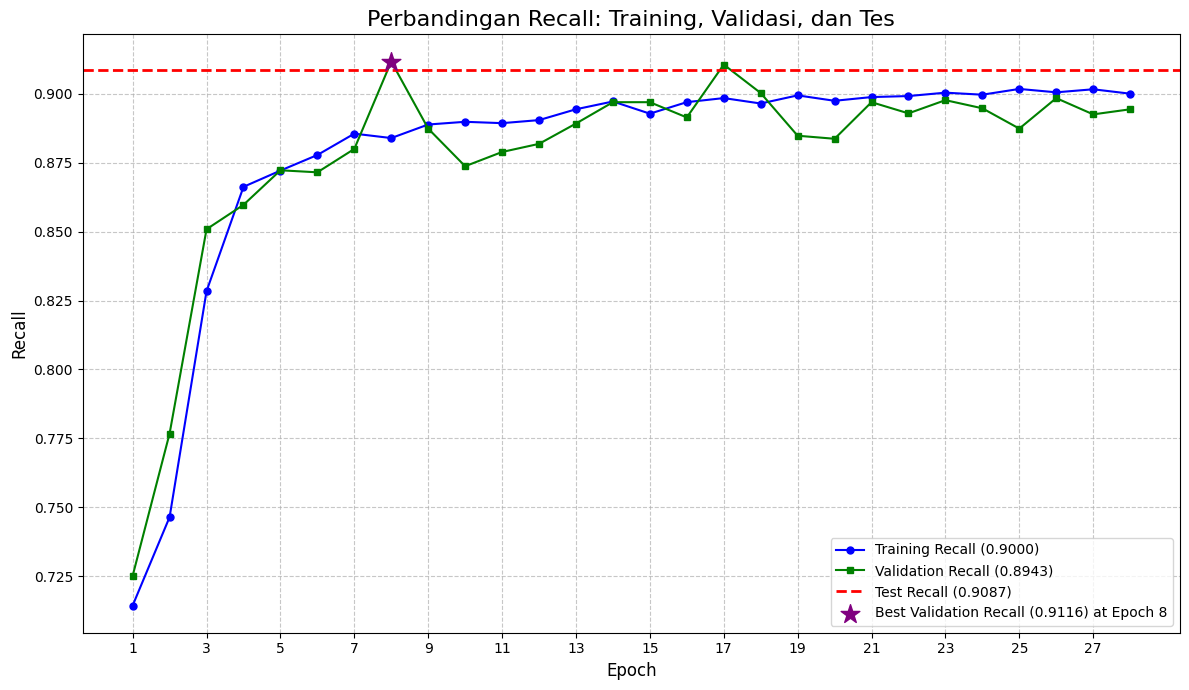

In [28]:
plot_recall_comparison(history, test_recall_value_untuk_plot)

In [3]:
import os

MODEL_CHECKPOINT_DIR = "model_checkpoints_recall_focused"
TENSORBOARD_LOG_DIR = "tensorboard_logs_recall_focused"
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(TENSORBOARD_LOG_DIR, exist_ok=True)

# Pastikan 'val_recall_class_1' adalah nama metrik yang benar di history.history
checkpoint_filepath = os.path.join(MODEL_CHECKPOINT_DIR, "best_recall_model.keras") # Nama file sederhana untuk yang terbaik

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight # Untuk menghitung class weights
import os
import datetime

In [5]:
checkpoint_filepath

'model_checkpoints_recall_focused\\best_recall_model.keras'

In [6]:
# panggil model best_recall_model.keras
model_best = keras.models.load_model(checkpoint_filepath)
model_best.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,413 (130.52 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,276 (87.02 KB)

In [11]:
# convert model_best to .h5
model_best_h5_path = os.path.join(MODEL_CHECKPOINT_DIR, "best_recall_model.h5")
model_best.save(model_best_h5_path, save_format='h5')

In [7]:
# loac model_best_h5
model_best_h5_path = os.path.join(MODEL_CHECKPOINT_DIR, "best_recall_model.h5")
model_best_h5 = keras.models.load_model(model_best_h5_path)
model_best_h5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,139 (43.52 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import os

# Menampilkan direktori saat ini
print("Direktori saat ini:", os.getcwd())



Direktori saat ini: d:\Capstone\ML - Phishing Detection\Phishing-Detection\src\models


In [16]:

# pindah ke path
os.chdir(os.path.join(os.getcwd(), 'models_trained'))

print("Direktori setelah pindah:", os.getcwd())

Direktori setelah pindah: d:\Capstone\ML - Phishing Detection\Phishing-Detection\models_trained


In [18]:
model_best_h5_path = os.path.join(os.getcwd(), "best_recall_model.h5")
model_best.save(model_best_h5_path, save_format='h5')
print(f"Model disimpan sebagai: {model_best_h5_path}")

Model disimpan sebagai: d:\Capstone\ML - Phishing Detection\Phishing-Detection\models_trained\best_recall_model.h5


In [1]:
import h5py
print(h5py.__version__)


3.11.0
